In [1]:
import timeit
import neater_cnc_tableau as cnc
import numpy as np
import timeit
from random import choice
import chp

In [2]:
# generate random cliffords:
def generate_gate_sequence(n, beta):
    """Generate a random sequence of Clifford gates."""
    num_gates = int(beta * n) #* np.log2(n)
    gates = ['h', 's', 'cnot']
    sequence = []
    for _ in range(num_gates):
        gate = choice(gates)
        if gate == 'h' or gate == 's':  # Single qubit gates
            qubit = np.random.randint(0, n)
            sequence.append(f"{gate}_{qubit}")
        elif gate == 'cnot':  # Two-qubit gate
            control = np.random.randint(0, n)
            target = np.random.randint(0, n)
            while target == control:  # Ensure control != target
                target = np.random.randint(0, n)
            sequence.append(f"{gate}_{control}_{target}")
    return sequence


In [3]:
# apply random gate sequence with cnc sim:
def apply_sequence_of_clifford(simulator, sequence):
    """Apply a sequence of Clifford gates to the simulator."""
    for gate in sequence:
        if gate.startswith('h'):
            qubit = int(gate.split('_')[1])
            simulator.apply_hadamard(qubit)
        elif gate.startswith('s'):
            qubit = int(gate.split('_')[1])
            simulator.apply_phase(qubit)
        elif gate.startswith('cnot'):
            control, target = map(int, gate.split('_')[1:])
            simulator.apply_cnot(control, target)

In [4]:
# Loop over beta and n ranges
beta_min = 1.0; beta_max = 1.01; delta = 0.4
beta_values = np.arange(beta_min, beta_max, delta)

# define qubit ranges:
n_min = 200; n_max = 1001; n_delta = 50
n_values = range(n_min, n_max, n_delta)  # n from 200 to 2000

m = "vary"

results = []

for beta in beta_values:
    for n in n_values:
        print(f"Running simulation for beta={beta:.1f}, n={n}")

        # Generate Clifford gate sequence
        sequence = generate_gate_sequence(n, beta)

        # Initialize the CNC simulator
        em = int(n/2)
        simulator = cnc.CncSimulator(n, em)

        # Apply the gate sequence
        apply_sequence_of_clifford(simulator, sequence)

        # Prepare measurement bases
        zero_matrix = np.zeros((n, n), dtype=int)
        identity_matrix = np.eye(n, dtype=int)
        measurement_bases = np.hstack((identity_matrix,zero_matrix))

        # Define the setup code
        setup_code = f"""
import numpy as np
from __main__ import simulator, measurement_bases
"""

        # Define the statement to measure
        stmt_code = """
for base in range(measurement_bases.shape[0]):
    simulator.measure(measurement_bases[base, :])
"""

        # Time the execution
        repeat = 5
        execution_time = timeit.timeit(stmt=stmt_code, setup=setup_code, number=repeat)
        avg_time = execution_time /(repeat*n)
        print(f"Average time per iteration for beta={beta:.1f}, n={n}: {avg_time:.6f} seconds")

        # Store results
        results.append((beta, n, avg_time))

# Print all results
for beta, n, avg_time in results:
    print(f"Beta={beta:.1f}, n={n}, Avg Time={avg_time:.6f} seconds")

# Save to .npy file
np.save(f"./figures/cnc_measurement_n_{n_min}_{n_max}_{n_delta}_m_{m}_beta_{beta_min}_{beta_max}_{delta}.npy", np.array(results))


Running simulation for beta=1.0, n=200
Average time per iteration for beta=1.0, n=200: 0.000542 seconds
Running simulation for beta=1.0, n=250
Average time per iteration for beta=1.0, n=250: 0.001023 seconds
Running simulation for beta=1.0, n=300
Average time per iteration for beta=1.0, n=300: 0.001319 seconds
Running simulation for beta=1.0, n=350
Average time per iteration for beta=1.0, n=350: 0.001613 seconds
Running simulation for beta=1.0, n=400
Average time per iteration for beta=1.0, n=400: 0.002025 seconds
Running simulation for beta=1.0, n=450
Average time per iteration for beta=1.0, n=450: 0.002425 seconds
Running simulation for beta=1.0, n=500
Average time per iteration for beta=1.0, n=500: 0.002946 seconds
Running simulation for beta=1.0, n=550
Average time per iteration for beta=1.0, n=550: 0.002039 seconds
Running simulation for beta=1.0, n=600
Average time per iteration for beta=1.0, n=600: 0.003122 seconds
Running simulation for beta=1.0, n=650
Average time per iteratio

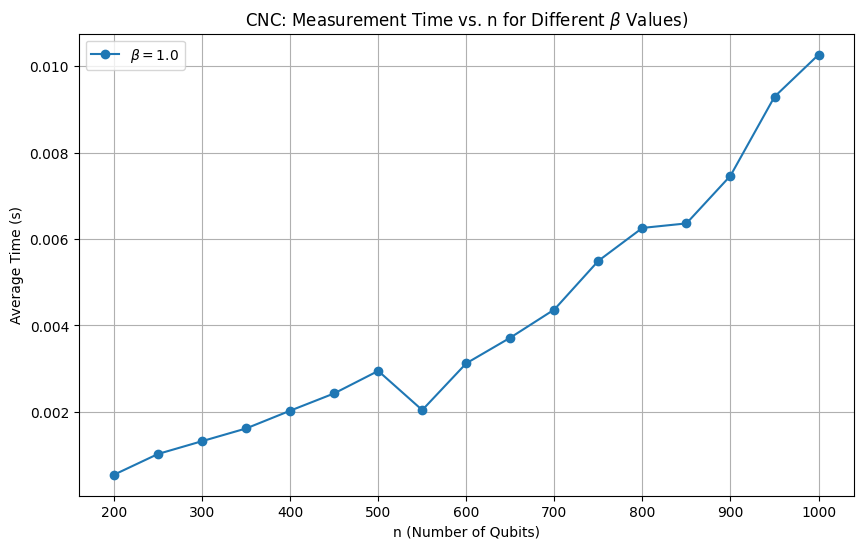

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Your numpy array
data = np.array(results)

# Extract unique beta values
betas = np.unique(data[:, 0])

# Create the plot
plt.figure(figsize=(10, 6))

for beta in betas:
    subset = data[data[:, 0] == beta]  # Filter rows with the current beta
    n = subset[:, 1]
    avg_time = subset[:, 2]
    plt.plot(n, avg_time, marker='o', label=f"$\\beta={round(beta,1)}$")  # LaTeX syntax for beta

# Label the axes and add a legend
plt.xlabel("n (Number of Qubits)")
plt.ylabel("Average Time (s)")
plt.title(f"CNC: Measurement Time vs. n for Different $\\beta$ Values)")  # Use beta in title
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig(f"./figures/cnc_measurement_plot_n_{n_min}_{n_max}_{n_delta}_m_{m}_beta_{beta_min}_{beta_max}_{delta}.png", format="png", dpi=300)

# Show the plot (optional)
plt.show()

# Comparison with CHP

In [5]:
def apply_sequence_of_clifford_chp(simulator, sequence):
    """Apply a sequence of Clifford gates to the simulator."""
    for gate in sequence:
        if gate.startswith('h'):
            qubit = int(gate.split('_')[1])
            simulator.hadamard(qubit)
        elif gate.startswith('s'):
            qubit = int(gate.split('_')[1])
            simulator.phase(qubit)
        elif gate.startswith('cnot'):
            control, target = map(int, gate.split('_')[1:])
            simulator.cnot(control, target)

In [38]:
# Loop over beta and n ranges
beta_min = 0.6; beta_max = 1.41; delta = 0.4
beta_values = np.arange(beta_min, beta_max, delta)

# define qubit ranges:
n_min = 200; n_max = 1001; n_delta = 100
n_values = range(n_min, n_max, n_delta)  # n from 200 to 2000

results = []

for beta in beta_values:
    for n in n_values:
        print(f"Running simulation for beta={beta:.1f}, n={n}")

        # Generate Clifford gate sequence
        sequence = generate_gate_sequence(n, beta)

        simulator = chp.ChpSimulator(n)

        # Apply the gate sequence
        apply_sequence_of_clifford_chp(simulator, sequence)

        # Define the setup code
        setup_code = f"""
import numpy as np
from __main__ import simulator, n
"""

        # Define the statement to measure
        stmt_code = """
for qubit in range(n):
    simulator.measure(qubit)
"""

        # Time the execution
        repeat = 4
        execution_time = timeit.timeit(stmt=stmt_code, setup=setup_code, number=repeat)
        avg_time = execution_time /(repeat*n)
        print(f"Average time per iteration for beta={beta:.1f}, n={n}: {avg_time:.6f} seconds")

        # Store results
        results.append((beta, n, avg_time))

# Print all results
for beta, n, avg_time in results:
    print(f"Beta={beta:.1f}, n={n}, Avg Time={avg_time:.6f} seconds")

# Save to .npy file
np.save(f"./figures/chp_measurement_n_{n_min}_{n_max}_{n_delta}_beta_{beta_min}_{beta_max}_{delta}.npy", np.array(results))


Running simulation for beta=0.6, n=200
Average time per iteration for beta=0.6, n=200: 0.000186 seconds
Running simulation for beta=0.6, n=300
Average time per iteration for beta=0.6, n=300: 0.000288 seconds
Running simulation for beta=0.6, n=400
Average time per iteration for beta=0.6, n=400: 0.000502 seconds
Running simulation for beta=0.6, n=500
Average time per iteration for beta=0.6, n=500: 0.000705 seconds
Running simulation for beta=0.6, n=600
Average time per iteration for beta=0.6, n=600: 0.000750 seconds
Running simulation for beta=0.6, n=700
Average time per iteration for beta=0.6, n=700: 0.001035 seconds
Running simulation for beta=0.6, n=800
Average time per iteration for beta=0.6, n=800: 0.001321 seconds
Running simulation for beta=0.6, n=900
Average time per iteration for beta=0.6, n=900: 0.001467 seconds
Running simulation for beta=0.6, n=1000
Average time per iteration for beta=0.6, n=1000: 0.002013 seconds
Running simulation for beta=1.0, n=200
Average time per iterat

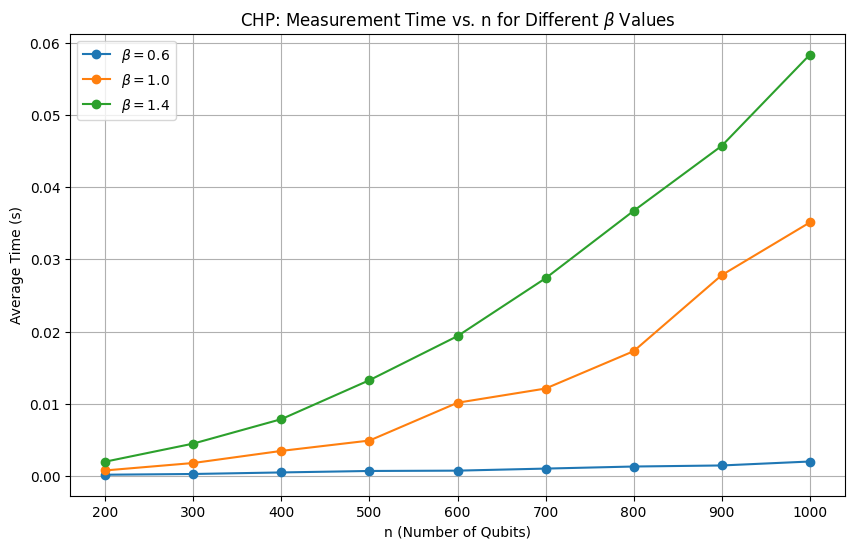

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Your numpy array
data = np.array(results)

# Extract unique beta values
betas = np.unique(data[:, 0])

# Create the plot
plt.figure(figsize=(10, 6))

for beta in betas:
    subset = data[data[:, 0] == beta]  # Filter rows with the current beta
    n = subset[:, 1]
    avg_time = subset[:, 2]
    plt.plot(n, avg_time, marker='o', label=f"$\\beta={round(beta,1)}$")  # LaTeX syntax for beta

# Label the axes and add a legend
plt.xlabel("n (Number of Qubits)")
plt.ylabel("Average Time (s)")
plt.title(f"CHP: Measurement Time vs. n for Different $\\beta$ Values")  # Use beta in title
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig(f"./figures/chp_measurement_plot_n_{n_min}_{n_max}_{n_delta}_beta_{beta_min}_{beta_max}_{delta}.npy.png", format="png", dpi=300)

# Show the plot (optional)
plt.show()

In [5]:
import matplotlib.pyplot as plt
import numpy as np

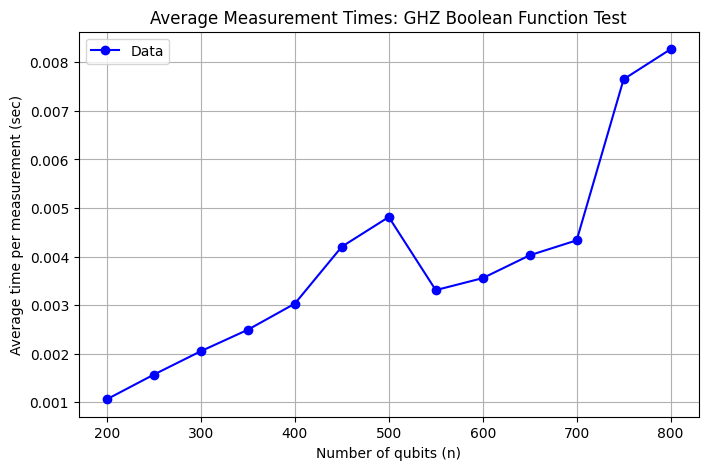

In [7]:
data = np.load("./avg_measurement_times.npy")

# Extracting x and y values
x_values = data[:, 0]
y_values = data[:, 1]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label='Data')

# Labels and title
plt.xlabel('Number of qubits (n)')
plt.ylabel('Average time per measurement (sec)')
plt.title('Average Measurement Times: GHZ Boolean Function Test')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()